# MNIST VAE Model

In [1]:
#Import our necessary packages
import torch
import torch.nn.functional as F
from torch import nn

#intialize the VAE class

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim_fin = 200, z_dim = 20):
        super().__init__()
        
        self.bn1 = nn.BatchNorm1d(400)
        self.bn2 = nn.BatchNorm1d(200)
        
        #encoder
        self.img_to_hid1 = nn.Linear(input_dim, 400)
        self.hid1_to_hid2 = nn.Linear(400, hidden_dim_fin)
        self.hid2_to_mu = nn.Linear(hidden_dim_fin, z_dim)
        self.hid2_to_sigma = nn.Linear(hidden_dim_fin, z_dim)
        
        
        #decoder
        self.z_to_hid2 = nn.Linear(z_dim, hidden_dim_fin)
        self.hid2_to_hid1 = nn.Linear(hidden_dim_fin, 400)
        self.hid1_to_img = nn.Linear(400, input_dim)
        
        self.relu = nn.ReLU()
        
 #Steps: Input -> Hidden dim -> Mean & Std
        # Mean & Std -> reparameterization trick applied 
        # from there that is passed through the decoder -> output
        
    def encode(self, x):
        # q_phi(z|x)
        
        #apply batch normalization after first dimension reduction
        h_1 = self.bn1(self.img_to_hid1(x))
        #Pass the output through next dimension reduction function to get to the final hidden state then apply the relu activation function
        h_fin = self.relu(self.hid1_to_hid2(h_1))
        mu, sigma = self.hid2_to_mu(h_fin), self.hid2_to_sigma(h_fin)
        
        return mu, sigma
    
    
    def decode(self, z):
        #p_theta(x|z)
        
        #applying batch normalization after the first linear transformation
        h_a = self.bn2(self.z_to_hid2(z))
        #Applying the second linear transformation before relu activation function
        h_b = self.relu(self.hid2_to_hid1(h_a))
        
        return torch.sigmoid(self.hid1_to_img(h_b)) #the values for the pixels have to be between 0 and 1 might be diff for other purposes
    
    
    
    def forward(self, x):
        mu, sigma = self.encode(x)
        #reparameterization trick applied here
        epsilon = torch.randn_like(sigma)
        z_reparametrized = mu + sigma*epsilon
        
        x_reconstructed = self.decode(z_reparametrized)
        
        return x_reconstructed, mu, sigma
        
    
    
if __name__ == "__main__":
    #To test that we wrote the function well we use a random x: Follow code
    x = torch.randn(4, 28*28) # 28*28 input_dim = 784
    vae = VAE(input_dim=784)
    x_reconstructed, mu, sigma = vae(x)
    print(x_reconstructed.shape)
    print(mu.shape)
    print(sigma.shape)

torch.Size([4, 784])
torch.Size([4, 20])
torch.Size([4, 20])


## Model Training 

In [3]:
#importting necessaru packages for data and training 
import torch
import torchvision.datasets as datasets
from tqdm import tqdm
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader 

#configuration

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

INPUT_DIM = 784
HIDDEN_DIM = 200
Z_DIM = 20
NUM_EPOCHS = 15 
BATCH_SIZE = 32 
LR_RATE = 0.0001


#Dataset Loading
dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)

model = VAE(INPUT_DIM, HIDDEN_DIM, Z_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR_RATE)
loss_fn = nn.BCELoss(reduction="sum")


#Initiating training

for epoch in range(NUM_EPOCHS):
    loop = tqdm(enumerate(train_loader))
    for i, (x, label) in loop:
        #fowardpass
        x = x.to(DEVICE).view(x.shape[0], INPUT_DIM)
        x_reconstructed, mu, sigma = model(x)
        
        
        #compute loss
        reconstruction_loss = loss_fn(x_reconstructed, x)
        kl_div = -torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2)) # this will push the latent space towards standard gaussian
        
        #Backprop
        loss = reconstruction_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loop.set_postfix(loss=loss.item())



/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
1875it [00:12, 150.14it/s, loss=5.84e+3]
1875it [00:12, 152.61it/s, loss=5.7e+3] 
1875it [00:11, 164.44it/s, loss=5.79e+3]
1875it [00:11, 163.88it/s, loss=4.89e+3]
1875it [00:11, 163.18it/s, loss=5.01e+3]
1875it [00:12, 154.90it/s, loss=4.83e+3]
1875it [00:12, 155.88it/s, loss=4.9e+3] 
1875it [00:12, 155.12it/s, loss=4.89e+3]
1875it [00:12, 154.45it/s, loss=5.28e+3]
1875it [00:12, 153.47it/s, loss=4.9e+3] 
1875it [00:12, 153.02it/s, loss=4.95e+3]
1875it [00:12, 153.01it/s, loss=5.03e+3]
1875it [00:12, 155.47it/s, loss=4.89e+3]
1875it [00:12, 154.07it/s, loss=4.82e+3]
1875it [00:12, 153.92it/s, loss=5.14e+3]


## Sampling random points in the latent space

In [4]:
import torch
from torchvision.utils import save_image

# Setting the model to evaluation mode
# And No gradient tracking needed during generation
model.eval()


with torch.no_grad():
    z = torch.randn(64, Z_DIM).to(DEVICE) #sampling 64 random points in the latent space
    generated = model.decode(z)
    
    # Reshaping the output and save it as an image grid (8x8)
    save_image(generated.view(-1, 1, 28, 28), "generated_digits.png", nrow=8, normalize=True)


## Regeneration of Real Images to Test Model Performance

In [8]:
dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

real_images, labels = next(iter(data_loader))
real_images = real_images.to(DEVICE).view(BATCH_SIZE, -1)

# Setting model to eval mode
model.eval()

with torch.no_grad():
    mu, _ = model.encode(real_images)
    
    # Decode using mu (not z = mu + sigma * epsilon)
    recon = model.decode(mu)
    
    # Saving real and reconstructed images side by side
    all_images = torch.cat([real_images, recon], dim=0)
    save_image(all_images.view(-1, 1, 28, 28), "real_vs_recon.png", nrow=BATCH_SIZE, normalize=True)

## UMAP of Latent Space Distribution

/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


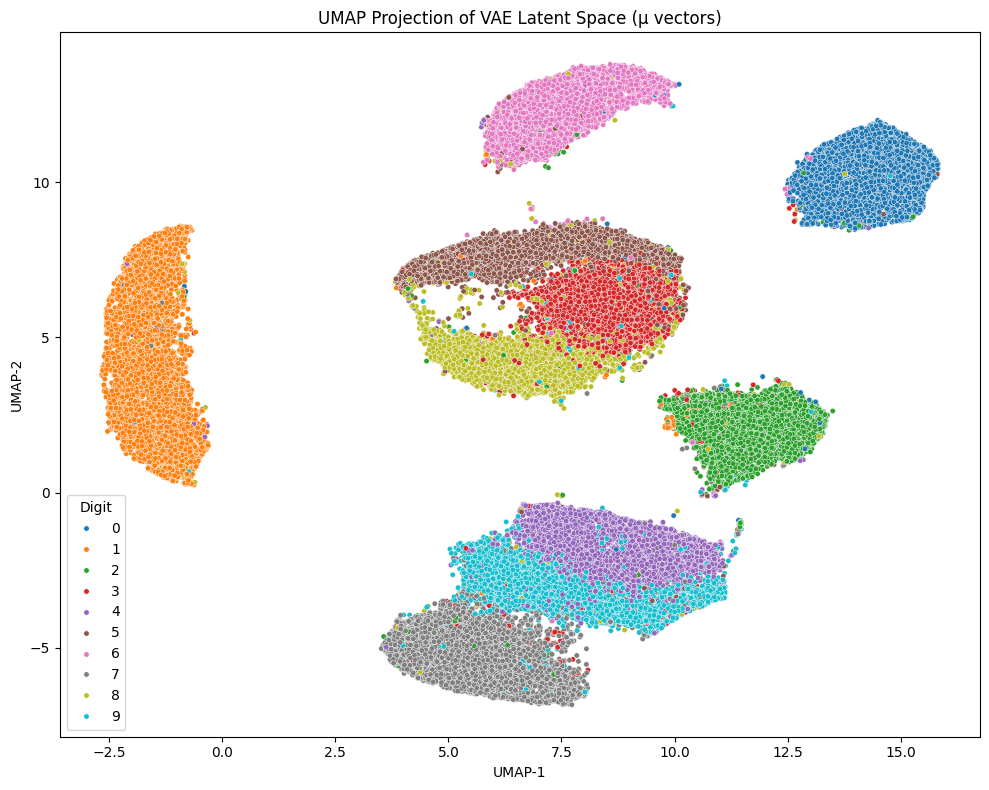

In [12]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import umap
import matplotlib.pyplot as plt
import seaborn as sns


dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms.ToTensor(), download=True)
loader = DataLoader(dataset, batch_size=128, shuffle=False)

all_mu = []
all_labels = []

model.eval()
with torch.no_grad():
    for x, labels in loader:
        x = x.to(DEVICE).view(x.size(0), -1)
        mu, _ = model.encode(x)
        all_mu.append(mu.cpu())
        all_labels.append(labels)

all_mu = torch.cat(all_mu).numpy()
all_labels = torch.cat(all_labels).numpy()

#UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(all_mu)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=all_labels, palette="tab10", legend="full", s=15)
plt.title("UMAP Projection of VAE Latent Space (μ vectors)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Digit")
plt.tight_layout()
plt.savefig("latent_space_UMAP.png")
plt.show()
